In [127]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
from imageio import imread

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [128]:
# Import the model
vggnet = tv.models.vgg19(pretrained=True)

# Freeze all layers
for p in vggnet.parameters():
    p.requires_grad_(False)

# Set to evalution mode
vggnet.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [129]:
# Summery of the model
# summary(vggnet)

In [130]:
# Push the model to the GPU
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [131]:
# # Import the content and style images
# img4content = imread(
#     "https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg"
# )
# img4style = imread(
#     "https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg"
# )

# # Initialize the target image and random numbers
# img4target = np.random.randint(low=0, high=255, size=img4content.shape, dtype=np.uint8)

# print(img4content)
# print(img4target)
# print(img4style.shape)

# Import the content and style images
img4content = imread(
    "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fthepurbottar.in%2Fwp-content%2Fuploads%2F2024%2F05%2Fpriyanka-chopra-1-1716893102.jpg&f=1&nofb=1&ipt=1dd765f6b8590eb467bbb4c61c5aeba09d05a3b9f913ac4e098ff9cb7ce533e9"
)
img4style = imread(
    "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn11.bigcommerce.com%2Fs-5qm28d53av%2Fimages%2Fstencil%2F1280w%2Fproducts%2F330%2F9318%2FWoman-s-head-and-self-portrait-1929-Picasso__04078.1586802926.jpg%3Fc%3D1&f=1&nofb=1&ipt=7bdde8c5772c9d75a77812b75f747e4a8a697757996aae9a36b39e3001312889"
)

# Initialize the target image and random numbers
img4target = np.random.randint(low=0, high=255, size=img4content.shape, dtype=np.uint8)

print(img4content)
print(img4target)
print(img4style.shape)

/tmp/ipykernel_3001/3738118299.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread(
/tmp/ipykernel_3001/3738118299.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style = imread(


[[[ 87  30   3]
  [ 88  31   4]
  [ 89  32   5]
  ...
  [ 96  35   4]
  [ 96  35   4]
  [ 95  34   3]]

 [[ 87  30   3]
  [ 88  31   4]
  [ 89  32   5]
  ...
  [ 95  34   3]
  [ 95  34   3]
  [ 95  34   3]]

 [[ 87  30   3]
  [ 88  31   4]
  [ 89  32   5]
  ...
  [ 95  34   3]
  [ 95  34   3]
  [ 95  34   3]]

 ...

 [[118  52  17]
  [119  53  18]
  [120  54  19]
  ...
  [168  91  49]
  [175  93  53]
  [179  98  55]]

 [[121  55  20]
  [121  55  20]
  [121  55  20]
  ...
  [168  91  49]
  [174  92  52]
  [178  97  54]]

 [[124  56  19]
  [124  56  19]
  [123  55  20]
  ...
  [167  90  46]
  [174  93  50]
  [178  97  54]]]
[[[248 128 132]
  [ 50 179 168]
  [ 25 225  77]
  ...
  [151 190 109]
  [188 146 207]
  [242 163  23]]

 [[178 149 246]
  [ 46  64 182]
  [148  98 194]
  ...
  [144 210  54]
  [175 163 108]
  [ 88 139 194]]

 [[ 45 177  51]
  [ 72 249 201]
  [226   8 231]
  ...
  [ 54 130  89]
  [188 173   8]
  [108 146  14]]

 ...

 [[227  68 214]
  [186 249 110]
  [ 77  28   7]
  ..

In [132]:
## Reducing image dimention as bigger image will take forever to train

# Create transform
Ts = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts(img4content).unsqueeze(0).to(device)
img4style = Ts(img4style).unsqueeze(0).to(device)
img4target = Ts(img4target).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 455])
torch.Size([1, 3, 256, 455])
torch.Size([1, 3, 328, 256])


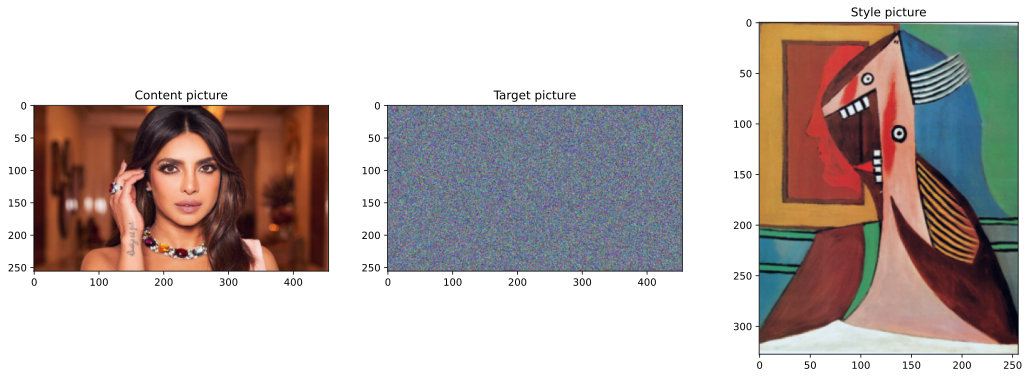

In [133]:
# Let's have a look at the "before" pics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pic = img4content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title("Content picture")

pic = img4target.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title("Target picture")

pic = img4style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title("Style picture")

plt.show()

In [134]:
# Function to extract image features map activations
def getFeatureMapActs(img, net):

    # Initialize feature maps as a list
    featuremaps = []
    featurenames = []

    convLayerIdx = 0

    # Loop through all layers in the features block
    for layernum in range(len(net.features)):

        # Print out info from this layer
        # print(layernum, net.features[layernum])

        # Process the image through this layer
        img = net.features[layernum](img)

        # Store the image if it's a conv2d layer
        if 'Conv2d' in str(net.features[layernum]):
            featuremaps.append(img)
            featurenames.append('ConvLayer_' + str(convLayerIdx))
            convLayerIdx += 1
    
    return featuremaps, featurenames




In [135]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):
    # Reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans, height * width)

    # Compute and return covariance matrix
    gram = torch.mm(M, M.t()) / (chans * height * width)
    
    return gram

In [136]:
# Inspect the output of the function
featmaps, featnames = getFeatureMapActs(img4content, vggnet)

# Print out some info
for i in range(len(featnames)):
    print('Feature map "%s" is size %s'%(featnames[i], (featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 455])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 455])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 227])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 227])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 113])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 113])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 113])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 113])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 56])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 56])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 56])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 56])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_15" is size torch

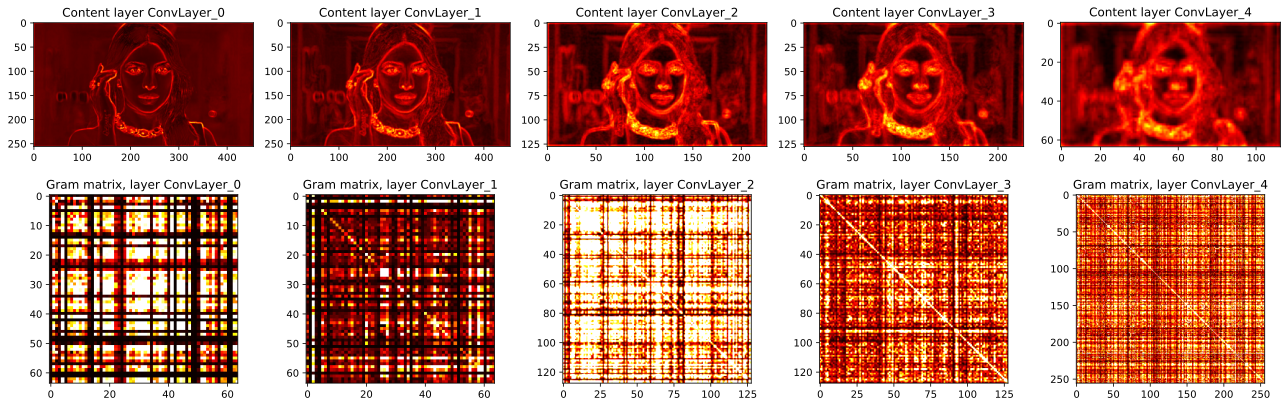

In [137]:
# let's see what the "content" image looks like
contentFeatureMaps, contentFeatureNames = getFeatureMapActs(img4content, vggnet)

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean(contentFeatureMaps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap="hot")
    axs[0, i].set_title("Content layer " + str(contentFeatureNames[i]))

    ### now show the gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1, i].imshow(pic, cmap="hot", vmax=0.1)
    axs[1, i].set_title("Gram matrix, layer " + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

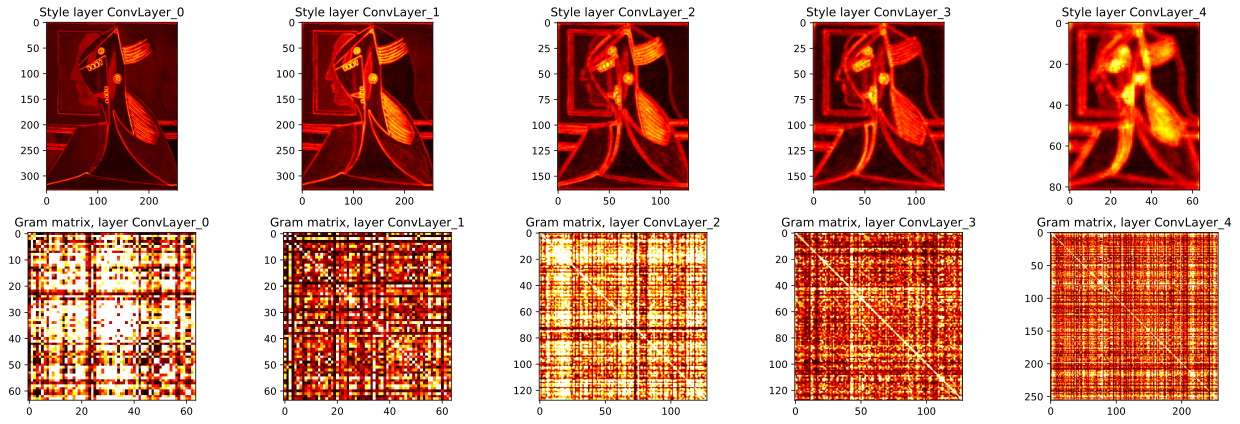

In [138]:
# repeat for the "style" image
styleFeatureMaps, styleFeatureNames = getFeatureMapActs(img4style, vggnet)


fig, axs = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean(styleFeatureMaps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap="hot")
    axs[0, i].set_title("Style layer " + str(styleFeatureNames[i]))

    ### now show the gram matrix
    pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1, i].imshow(pic, cmap="hot", vmax=0.1)
    axs[1, i].set_title("Gram matrix, layer " + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

In [139]:
targetFeatureMaps, targetFeatureNames = getFeatureMapActs(img4target, vggnet)
print(targetFeatureNames)
# which layers to use
# which layers to use
layers4content = ["ConvLayer_1", "ConvLayer_4"]
layers4style = [
    "ConvLayer_1",
    "ConvLayer_2",
    "ConvLayer_3",
    "ConvLayer_4",
    "ConvLayer_5",
]
weights4style = [1, 0.5, 0.5, 0.2, 0.1]

['ConvLayer_0', 'ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4', 'ConvLayer_5', 'ConvLayer_6', 'ConvLayer_7', 'ConvLayer_8', 'ConvLayer_9', 'ConvLayer_10', 'ConvLayer_11', 'ConvLayer_12', 'ConvLayer_13', 'ConvLayer_14', 'ConvLayer_15']


In [ ]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6
# Number of epochs to train
numepochs = 4000
losses = np.zeros((2, numepochs))

# Optimizer for backprop
optimizer = torch.optim.RMSprop([target], lr=0.005)

for epoch in range(numepochs):
    # extract the target feature maps
    targetFeatureMaps, targetFeatureNames = getFeatureMapActs(target, vggnet)

    # Initialize the individual loss components
    styleLoss = 0
    contentLoss = 0

    # loop over layers
    for layer in range(len(targetFeatureNames)):
        # Compute the content loss
        if targetFeatureNames[layer] in layers4content:
            contenLoss_temp = torch.mean(
                (targetFeatureMaps[layer] - contentFeatureMaps[layer]) ** 2
            )
            contentLoss += contenLoss_temp
            losses[0][i] = contenLoss_temp.item()

        # Compute the style loss
        if targetFeatureNames[layer] in layers4style:
            # Garam matrices
            Gtarget = gram_matrix(targetFeatureMaps[layer])
            Gstyle = gram_matrix(styleFeatureMaps[layer])

            # Compute their loss (de-weighted with increasing dept)
            # print(layer)
            # print(targetFeatureNames[layer])
            styleLoss_temp = torch.mean((Gtarget - Gstyle) ** 2)* weights4style[layers4style.index(targetFeatureNames[layer])]
            styleLoss += styleLoss_temp
            losses[1][i] = styleLoss_temp.item()

    # Combine loss
    combineloss = styleScaling * styleLoss + contentLoss

    # Finally ready for backprop
    optimizer.zero_grad()
    combineloss.backward()
    optimizer.step()

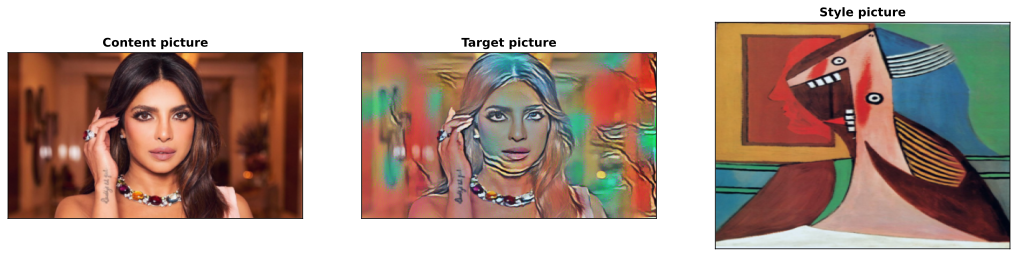

In [ ]:
# Let's have a look
# the "after" pic
fig, ax = plt.subplots(1, 3, figsize=(18, 11))

pic = img4content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title("Content picture", fontweight="bold")
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1, 2, 0))
ax[1].imshow(pic)
ax[1].set_title("Target picture", fontweight="bold")
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic, aspect=0.6)
ax[2].set_title("Style picture", fontweight="bold")
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

0.0 1.0795710068123299e-06


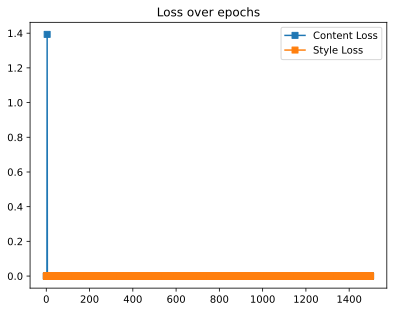

In [ ]:
print(np.min(losses[1]), np.max(losses[1]))
plt.plot(losses[0], 's-', label="Content Loss")
plt.plot(losses[1], 's-', label="Style Loss")
plt.title('Loss over epochs')
plt.legend()
plt.show()